In [59]:
from __future__ import annotations
import numpy as np

unexpanded_labels = np.load("/home/user/documents/PiereLab/lysozyme/lysozyme-stain-quantification/component development/mergeLogic/unmerged_labels_prev.npy")
expanded_labels = np.load("/home/user/documents/PiereLab/lysozyme/lysozyme-stain-quantification/component development/mergeLogic/unmerged_labels.npy")
label_img = expanded_labels.copy()

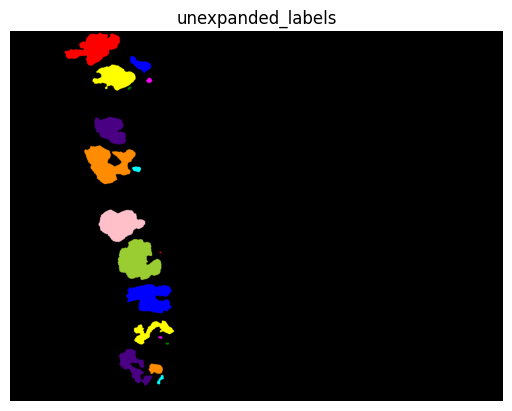

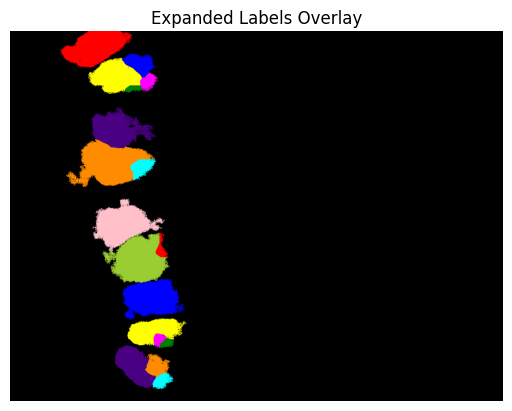

In [2]:

from skimage.color import label2rgb
from matplotlib import pyplot as plt

colored = label2rgb(unexpanded_labels, bg_label=0)

plt.imshow(colored)
plt.title("unexpanded_labels")
plt.axis('off')
plt.show()

colored = label2rgb(expanded_labels, bg_label=0)
plt.imshow(colored)
plt.title("Expanded Labels Overlay")
plt.axis('off')
plt.show()


1) Basic stats & adjacency

In [ ]:
#compute_stats_and_adjacency
import numpy as np
from skimage.measure import regionprops, perimeter
from skimage.morphology import dilation, rectangle
from itertools import combinations
from collections import defaultdict

def compute_stats_and_adjacency(label_img):
    props    = {r.label: r for r in regionprops(label_img)}
    perims   = {lbl: perimeter(label_img == lbl) for lbl in props}
    centroids= {lbl: props[lbl].centroid for lbl in props}
    areas    = {lbl: props[lbl].area     for lbl in props}
    
    # adjacency: shared perimeter between i↔j
    shared = defaultdict(lambda: defaultdict(int))
    for lbl in props:
        mask = label_img == lbl
        dil  = dilation(mask, rectangle(3,3))
        neighs = set(np.unique(label_img[dil])) - {0, lbl}
        for n in neighs:
            shared_p = int(np.logical_and(dil, label_img==n).sum())
            shared[lbl][n] = shared_p
            shared[n][lbl] = shared_p
    
    return props, perims, centroids, areas, shared

props, perims, cents, areas, shared = compute_stats_and_adjacency(expanded_labels)
print("Properties:", props)
print(shared)


Properties: {1: <skimage.measure._regionprops.RegionProperties object at 0x7f5b37844be0>, 2: <skimage.measure._regionprops.RegionProperties object at 0x7f5b37844400>, 3: <skimage.measure._regionprops.RegionProperties object at 0x7f5b372c1d60>, 4: <skimage.measure._regionprops.RegionProperties object at 0x7f5b372c1eb0>, 5: <skimage.measure._regionprops.RegionProperties object at 0x7f5b372c1b80>, 6: <skimage.measure._regionprops.RegionProperties object at 0x7f5b372c1e20>, 7: <skimage.measure._regionprops.RegionProperties object at 0x7f5b373f30d0>, 8: <skimage.measure._regionprops.RegionProperties object at 0x7f5b6c7e2f70>, 9: <skimage.measure._regionprops.RegionProperties object at 0x7f5b6c7e2fd0>, 10: <skimage.measure._regionprops.RegionProperties object at 0x7f5b6c7e2f10>, 11: <skimage.measure._regionprops.RegionProperties object at 0x7f5b6c7e2e80>, 12: <skimage.measure._regionprops.RegionProperties object at 0x7f5b6c7e2e50>, 13: <skimage.measure._regionprops.RegionProperties object at

In [ ]:
# Create a DataFrame from the shared adjacency dictionary
import pandas as pd

# Flatten shared adjacency into a list of 1-1 mappings
data = [
    {"label1": i, "label2": j, "shared_perimeter": w}
    for i, nbrs in shared.items()
    for j, w in nbrs.items()
    if i < j and w > 0
]

# Create DataFrame and display it
df = pd.DataFrame(data)
print(df)


    label1  label2  shared_perimeter
0        1       3                 6
1        3       4                27
2        3       5                54
3        2       3               100
4        2       4                30
5        4       5                16
6        6       7               109
7        7       8               125
8        9      10                70
9       10      11               101
10      10      12                32
11      13      14                76
12      13      15                22
13      14      15                43
14      16      17                93
15      16      18                35
16      17      18                41


/home/user/documents/PiereLab/lysozyme/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


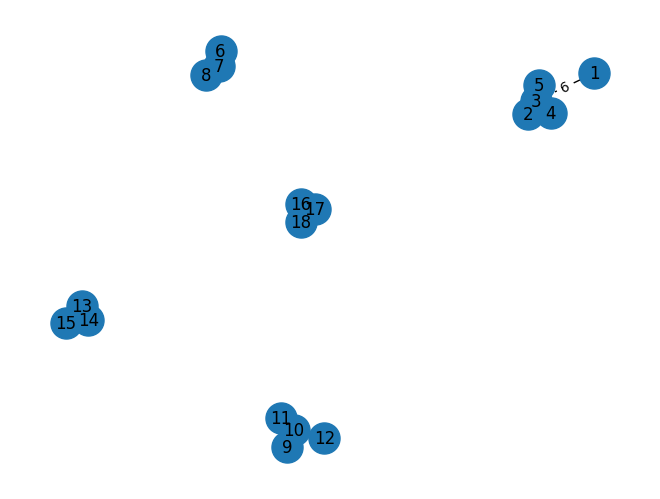

In [ ]:
# prety networkx visualization of the shared adjacency
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for i, nbrs in shared.items():
    for j, w in nbrs.items():
        if w>0 and i<j:
            G.add_edge(i, j, weight=w)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


# stage 1


## explaination
so now lets get on with the first stage merge evaluation, where we will go through each label, find all cliques up to 3 members in size which it is part of ( that includes the singleton self, any 2 memeber cliuques we can direclty pull from the mappings and then the triangles) we will then check against each triangle its a part of whether or not we should treat them as a chained unit ( i.e. if two triangles share 2 members including the label of interenst(so merge candidates can be larger then 3 memebrs by this)) 
then now against each of these candidite groups we have defined we will calculate the first parameter in oder to identify the best fit of nearby neigbors to eventualy merge it with.
i will be adjusting the parameters, but for now they will be: (total perimeter of the subject in contact with members of the merge candidate group)/( total perimeter of the subject(to avoid divide by 0 errors)), and against singletons it will be 1/ a factor passed as the argument, that way it will set like a minimum amount of coverage requireed

## find_triangles

In [68]:
#find_triangles
from collections import defaultdict
from itertools import combinations

def find_triangles(shared_adjacency):
    """
    Given a shared adjacency dictionary {label: {neighbor_label: shared_perimeter}},
    find all unique 3-cliques (triangles) where all three labels are mutually connected.
    
    Returns:
        triangles: List of tuples (a, b, c) where a, b, c are labels in a triangle.
    """
    triangles = set()
    for a in shared_adjacency:
        neighbors_a = set(shared_adjacency[a])
        for b, c in combinations(neighbors_a, 2):
            if b in shared_adjacency[c] and c in shared_adjacency[b]:
                triangle = tuple(sorted((a, b, c)))
                triangles.add(triangle)
    return sorted(triangles)

# # Example usage mock
# example_shared = {
#     1: {2: 5, 3: 5},
#     2: {1: 5, 3: 5},
#     3: {1: 5, 2: 5},
#     4: {5: 5},
#     5: {4: 5}
# }# note the :5 is a placeholder for shared perimeter, not used in this function

# triangles = find_triangles(example_shared)

# Example usage with actual shared adjacency
triangles = find_triangles(shared)
print("Triangles found:", triangles)

Triangles found: [(2, np.int32(3), np.int32(4)), (np.int32(3), np.int32(4), np.int32(5)), (13, np.int32(14), np.int32(15)), (16, np.int32(17), np.int32(18))]


## build_candidate_groups

In [ ]:
#build_candidate_groups
# remeber this ingnores labels that have no sharing, so need to reintegrate them later
def build_candidate_groups(shared, triangles, singleton_penalty=5.0):
    """
    For each label, generate all valid merge candidate groups:
    - Self group
    - Direct 2-member cliques
    - 3-member triangles
    - Chained triangles (sharing 2 nodes including current label)
    """
    # reverse index triangles by label
    triangle_index = defaultdict(list)
    for tri in triangles:
        for lbl in tri:
            triangle_index[lbl].append(tri)

    combos_by_label = defaultdict(list)
    for lbl in shared:
        # (1) Self combo
        combos_by_label[lbl].append((lbl,))

        # (2) 2-element combos
        for n in shared[lbl]:
            if n != lbl:
                # direct, directional pairings (had to get rid of deduplication bc it was making labels ignorant of merge options
                combos_by_label[lbl].append((lbl, n))

        # (3) 3-element triangles
        combos_by_label[lbl].extend(triangle_index[lbl])

        # (4) Extended groups via chained triangles
        seen = set()
        for tri1 in triangle_index[lbl]:
            for tri2 in triangle_index[lbl]:
                if tri1 == tri2:
                    continue
                inter = set(tri1).intersection(tri2)
                if len(inter) == 2 and lbl in inter:
                    merged = tuple(sorted(set(tri1).union(tri2)))
                    if merged not in seen:
                        combos_by_label[lbl].append(merged)
                        seen.add(merged)

    return combos_by_label
combos = build_candidate_groups(shared, triangles)
print("Combos by label:", combos)



Combos by label: defaultdict(<class 'list'>, {1: [(1,), (1, np.int32(3))], np.int32(3): [(np.int32(3),), (np.int32(3), 1), (np.int32(3), 2), (np.int32(3), np.int32(4)), (np.int32(3), np.int32(5)), (2, np.int32(3), np.int32(4)), (np.int32(3), np.int32(4), np.int32(5)), (2, np.int32(3), np.int32(4), np.int32(5))], 2: [(2,), (2, np.int32(3)), (2, np.int32(4)), (2, np.int32(3), np.int32(4))], np.int32(4): [(np.int32(4),), (np.int32(4), 2), (np.int32(4), 3), (np.int32(4), np.int32(5)), (2, np.int32(3), np.int32(4)), (np.int32(3), np.int32(4), np.int32(5)), (2, np.int32(3), np.int32(4), np.int32(5))], np.int32(5): [(np.int32(5),), (np.int32(5), 3), (np.int32(5), 4), (np.int32(3), np.int32(4), np.int32(5))], 6: [(6,), (6, np.int32(7))], np.int32(7): [(np.int32(7),), (np.int32(7), 6), (np.int32(7), np.int32(8))], np.int32(8): [(np.int32(8),), (np.int32(8), 7)], 9: [(9,), (9, np.int32(10))], np.int32(10): [(np.int32(10),), (np.int32(10), 9), (np.int32(10), np.int32(11)), (np.int32(10), np.int32

In [66]:
# Pretty-print the combos dictionary with indentation and newlines
for label, group_list in combos.items():
    print(f"Label {label}:")
    for group in group_list:
        group_str = ", ".join(str(int(x)) for x in group)
        print(f"\t{group_str}")
    print()

Label 1:
	1
	1, 3

Label 3:
	3
	3, 1
	3, 2
	3, 4
	3, 5
	2, 3, 4
	3, 4, 5
	2, 3, 4, 5

Label 2:
	2
	2, 3
	2, 4
	2, 3, 4

Label 4:
	4
	4, 2
	4, 3
	4, 5
	2, 3, 4
	3, 4, 5
	2, 3, 4, 5

Label 5:
	5
	5, 3
	5, 4
	3, 4, 5

Label 6:
	6
	6, 7

Label 7:
	7
	7, 6
	7, 8

Label 8:
	8
	8, 7

Label 9:
	9
	9, 10

Label 10:
	10
	10, 9
	10, 11
	10, 12

Label 11:
	11
	11, 10

Label 12:
	12
	12, 10

Label 13:
	13
	13, 14
	13, 15
	13, 14, 15

Label 14:
	14
	14, 13
	14, 15
	13, 14, 15

Label 15:
	15
	15, 13
	15, 14
	13, 14, 15

Label 16:
	16
	16, 17
	16, 18
	16, 17, 18

Label 17:
	17
	17, 16
	17, 18
	16, 17, 18

Label 18:
	18
	18, 16
	18, 17
	16, 17, 18



### selection explaination
Here’s exactly what’s happening, step by step, with notes on why each part is there:

---

## 1. Purpose

For each region (label), you have a set of “candidate groups” you might merge it with (itself, any 2-member pair, triangles, etc.).
This function **scores** each candidate and then picks the **highest-scoring** merge for each label.

---

## 2. Inputs

* **`combos_by_label`**:
  A dict mapping each label → list of tuples of labels, e.g.

  ```python
  { 
    1: [(1,), (1,2), (1,3), (1,2,3), …],
    2: [(2,), (2,1), (2,3), (2,1,3), …],
    …
  }
  ```
* **`perims`**:
  A dict mapping each label → its total exposed perimeter length (a float or int).
* **`shared`**:
  A nested dict mapping label → (other label → shared boundary length).
* **`singleton_penalty`** (default 10.0):
  A constant used to give singletons a low baseline score.

---

## 3. Initialization

```python
best_combo_by_label = {}
```

An empty dict where we’ll store, for each `lbl`, the tuple

```python
   ( best_combo_tuple, best_score )
```

---

## 4. Loop over each label

```python
for lbl, combo_list in combos_by_label.items():
    P = perims[lbl]
    best_score = -1.0
    best_combo = (lbl,)
```

* **`P`** is the perimeter of this label.
* **`best_score`** starts at –1 so that any non-negative score will beat it.
* **`best_combo`** initially set to the singleton—if no merge looks better, we’ll stay with `(lbl,)`.

---

## 5. Score each candidate

```python
for combo in combo_list:
    if combo == (lbl,):
        score = 1.0 / singleton_penalty
    else:
        shared_sum = sum(shared[lbl][n] for n in combo if n != lbl)
        score = shared_sum / (P + 1e-8)
```

1. **Singleton `(lbl,)`**

   * We don’t want “no merge” to win unless absolutely nothing else has shared boundary.
   * So we give it a small baseline of `1/penalty` (e.g. 0.1 when penalty=10).

2. **Multi-member groups**

   * We sum up **only** the boundary length this label shares with the others in that combo:

     ```python
     shared_sum = Σ shared[lbl][n]  for n in combo if n != lbl
     ```
   * Then divide by the label’s total perimeter `P` (plus a tiny `1e-8` guard to avoid divides by zero).
   * **Intuition**: This is “what fraction of this region’s border would be absorbed by the merge?”

---

## 6. Keep the best

```python
    if score > best_score:
        best_score = score
        best_combo = combo
```

After checking each `combo`, if its `score` is higher than the current `best_score`, we replace them.

---

## 7. Record and return

```python
best_combo_by_label[lbl] = (best_combo, best_score)
…
return best_combo_by_label
```

At the end you get a dict like:

```python
{
  1: ((1,3), 0.42),
  2: ((2,), 0.10),
  3: ((2,3), 0.35),
  …
}
```

– i.e. for each label, the single best merge candidate (and how well it scored).

---

## 8. Quick example

Say region 1 has:

* **Perimeter** `P = 50`
* **Shared boundaries** `shared[1][2] = 10`, `shared[1][3] = 20`
* **Candidates** `(1,)`, `(1,2)`, `(1,3)`, `(1,2,3)`

|   Combo   | shared\_sum | score = shared\_sum/P | notes                          |
| :-------: | :---------: | :-------------------: | :----------------------------- |
|   `(1,)`  |      —      |     `1/10 = 0.10`     | singleton baseline             |
|  `(1,2)`  |     `10`    |     `10/50 = 0.20`    | 20% of boundary merges         |
|  `(1,3)`  |     `20`    |     `20/50 = 0.40`    | 40%—best so far                |
| `(1,2,3)` |  `10+20=30` |     `30/50 = 0.60`    | actually the best overall here |

So the function would pick `(1,2,3)` with score `0.6`.


In [61]:
import pandas as pd

# assume `combos` is the dict returned by build_candidate_groups(...)
# e.g. combos = build_candidate_groups(shared, triangles)

# 1) Flatten into rows
rows = []
for lbl, group_list in combos.items():
    for group in group_list:
        rows.append({
            "label": lbl,
            "group": ", ".join(str(x) for x in group)
        })

# 2) Build DataFrame
df = pd.DataFrame(rows)

# 3) Print as a table
print(df.to_string(index=False))


 label      group
     1          1
     1       1, 3
     3          3
     3       3, 4
     3       3, 5
     3    2, 3, 4
     3    3, 4, 5
     3 2, 3, 4, 5
     2          2
     2       2, 3
     2       2, 4
     2    2, 3, 4
     4          4
     4       4, 5
     4    2, 3, 4
     4    3, 4, 5
     4 2, 3, 4, 5
     5          5
     5    3, 4, 5
     6          6
     6       6, 7
     7          7
     7       7, 8
     8          8
     9          9
     9      9, 10
    10         10
    10     10, 11
    10     10, 12
    11         11
    12         12
    13         13
    13     13, 14
    13     13, 15
    13 13, 14, 15
    14         14
    14     14, 15
    14 13, 14, 15
    15         15
    15 13, 14, 15
    16         16
    16     16, 17
    16     16, 18
    16 16, 17, 18
    17         17
    17     17, 18
    17 16, 17, 18
    18         18
    18 16, 17, 18


### table candidite groups

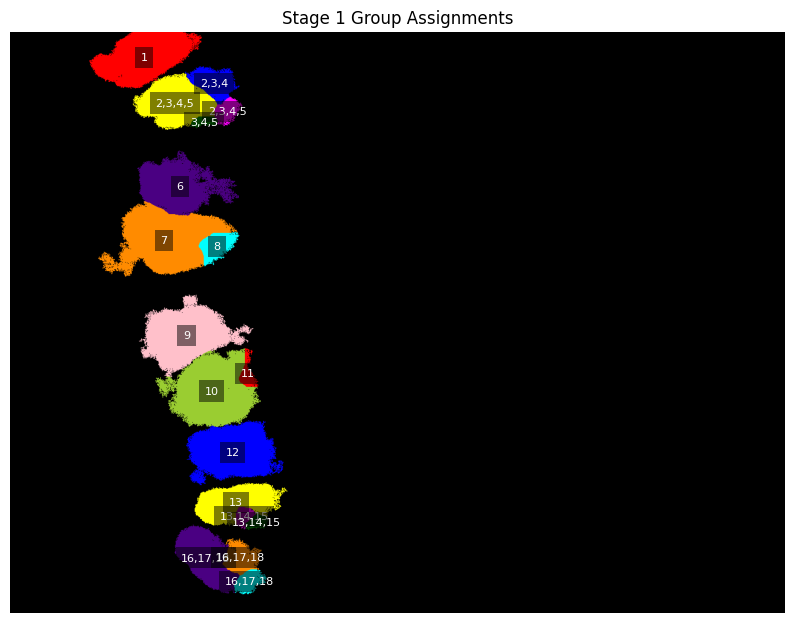

In [60]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.measure import regionprops
import numpy as np

def plot_stage1_groupings(label_array, best_stage1, background=0, title="Stage 1 Group Assignments"):
    """
    Plots label image colored by regions and overlays stage 1 group IDs.
    
    Args:
        label_array: np.ndarray with labeled regions.
        best_stage1: dict {label: (group_tuple, score)} from stage 1.
    """
    colored = label2rgb(label_array, bg_label=background)
    plt.figure(figsize=(10, 10))
    plt.imshow(colored)
    plt.title(title)
    plt.axis('off')

    # Determine regionprops
    regions = regionprops(label_array)

    for region in regions:
        label = region.label
        if label == background:
            continue
        y, x = region.centroid

        # Extract stage 1 group info
        group_tuple, score = best_stage1.get(label, ((label,), 0.0))
        group_id = ",".join(str(g) for g in sorted(group_tuple))

        # Draw group ID
        plt.text(x, y, group_id, color='white', fontsize=8, ha='center', va='center',
                 bbox=dict(facecolor='black', alpha=0.5, lw=0))

    plt.show()
plot_stage1_groupings(label_img, best_first_stage)


### 🧠 Core Logic Overview
find_triangles(shared)

Detects all 3-label cliques (fully connected triangles).

A triangle [A, B, C] is valid if A↔B, B↔C, and C↔A are all neighbors.

build_candidate_groups(shared, triangles)

For each label ℓ, builds a list of candidate groups to consider merging with:

Singleton group (ℓ,)

All direct 2-member pairs including ℓ

All triangles that include ℓ

Extended merge groups: formed by merging triangles that share 2 members including ℓ, allowing expansion beyond 3 elements

evaluate_first_stage_merges(...)

For each label ℓ, scores all candidate merge groups

Score formula:

If group is a singleton (ℓ,): 1 / singleton_penalty

Else: score = shared_perimeter_with_group / total_perimeter_of_ℓ

Selects the best scoring group as the first-stage merge candidate

## evaluate_first_stage_merges

In [44]:

def evaluate_first_stage_merges(combos_by_label, perims, shared, singleton_penalty=10.0):
    """
    Returns the best merge candidate for each label based on:
    - (total shared perimeter with group) / (total exposed perimeter)
    """
    best_combo_by_label = {}
    for lbl, combo_list in combos_by_label.items():
        P = perims[lbl]
        best_score = -1.0
        best_combo = (lbl,)
        for combo in combo_list:
            if combo == (lbl,):
                score = 1.0 / singleton_penalty
            else:
                shared_sum = sum(shared[lbl][n] for n in combo if n != lbl)
                score = shared_sum / (P + 1e-8)
            if score > best_score:
                best_score = score
                best_combo = combo
        best_combo_by_label[lbl] = (best_combo, best_score)
    return best_combo_by_label
best_stage1 = evaluate_first_stage_merges(combos, perims, shared)
print("Best first stage merges:", best_stage1)


Best first stage merges: {1: ((1,), 0.1), np.int32(3): ((2, np.int32(3), np.int32(4), np.int32(5)), np.float64(0.30533895899777613)), 2: ((2, np.int32(3), np.int32(4)), np.float64(0.3290580564834091)), np.int32(4): ((2, np.int32(3), np.int32(4), np.int32(5)), np.float64(0.2926428855009503)), np.int32(5): ((np.int32(3), np.int32(4), np.int32(5)), np.float64(0.5121633519985898)), 6: ((6,), 0.1), np.int32(7): ((np.int32(7),), 0.1), np.int32(8): ((np.int32(8),), 0.1), 9: ((9,), 0.1), np.int32(10): ((np.int32(10),), 0.1), np.int32(11): ((np.int32(11),), 0.1), np.int32(12): ((np.int32(12),), 0.1), 13: ((13, np.int32(14), np.int32(15)), np.float64(0.1415839984310492)), np.int32(14): ((13, np.int32(14), np.int32(15)), np.float64(0.8755292773417148)), np.int32(15): ((13, np.int32(14), np.int32(15)), np.float64(0.42756298145249255)), 16: ((16, np.int32(17), np.int32(18)), np.float64(0.24077698804485012)), np.int32(17): ((16, np.int32(17), np.int32(18)), np.float64(0.32179806622653784)), np.int32

# stage 2
so now the next step is stage 2, here we are going to go out and for each unique grouping of best first stage combos listed in best_first_stage, we will first identify the primary label of the grouping, which will based on most surface area (that going to be the one that the  other members of that grouping will join or follow if it ends up joining another larger group), then we will find all posible combinations of including every label neigboring the unique grouping and from each of those enighbors, the labels neigboring them, etc as long as they are still conected to the original grouping
and then once we have all of these posible extended groupings, we will evaluate the second parameter for each of the members of the original unique grouping ( need to only include the ones that were actualy assinged to them to account for edge cases like triangles sharing vertexes) even though we will be using all listed members to find neighbors)
the second parameter will for now work like this:
(total surface area)/(total exposed perimeter)/(average distance of label from center of mass of grouping(tho instead of like a centroid to centroid, this will be like a distance from a set of positions in the label to the group centroid))

## Step 1: Assign primary label per group

In [ ]:
from collections import defaultdict
import math
import numpy as np


def assign_group_leaders(best_stage1, areas):
    group_map = defaultdict(set)
    label_to_group = {}

    for label, (group, _) in best_stage1.items():
        norm_group = tuple(sorted(int(g) for g in group))
        group_map[norm_group].add(int(label))
        label_to_group[int(label)] = norm_group

    group_leaders = {}
    for group, members in group_map.items():
        # Choose leader as label with largest area
        leader = max(members, key=lambda x: areas[x])
        group_leaders[group] = leader

    return group_map, group_leaders, label_to_group



## Step 2: Build extended neighbors recursively

In [ ]:


def expand_neighbors(group, shared, visited=None):
    if visited is None:
        visited = set(group)
    for label in list(visited):
        for neighbor in shared[label]:
            if neighbor not in visited:
                visited.add(neighbor)
                expand_neighbors(group, shared, visited)
    return visited


## Step 3: Evaluate second-stage scores

In [ ]:


def compute_stage2_score(label, group, areas, perims, props, group_leader, sample_size=100, eps=1e-8):
    total_area = sum(areas[l] for l in group)
    total_perim = sum(perims[l] for l in group)
    coords = np.vstack([props[l].coords for l in group])
    group_centroid = coords.mean(axis=0)

    # Sample points from label and compute mean distance to group COM
    label_coords = props[label].coords
    if len(label_coords) > sample_size:
        indices = np.linspace(0, len(label_coords) - 1, sample_size).astype(int)
        label_sample = label_coords[indices]
    else:
        label_sample = label_coords
    dists = np.linalg.norm(label_sample - group_centroid, axis=1)
    avg_dist = dists.mean()

    score = (total_area / (total_perim + eps)) / (avg_dist + eps)
    return score


## Main stage 2 entrypoint

In [ ]:


def evaluate_second_stage_merges(best_stage1, shared, props, areas, perims, sample_size=100):
    group_map, group_leaders, label_to_group = assign_group_leaders(best_stage1, areas)

    second_stage_results = {}

    for group, members in group_map.items():
        leader = group_leaders[group]
        # Build candidate group: start with group members
        expanded_group = set(group)

        # Add direct neighbors of group labels
        for l in group:
            expanded_group.update(shared[l].keys())

        # Filter to only labels present in props
        expanded_group = {int(lbl) for lbl in expanded_group if int(lbl) in props}

        for label in members:
            score = compute_stage2_score(
                label, expanded_group, areas, perims, props, leader, sample_size=sample_size
            )
            second_stage_results[label] = (leader, score)

    # Add untouched singletons (not in best_stage1 or were self-only)
    all_labels = set(props.keys())
    processed_labels = set(second_stage_results.keys())
    unprocessed = all_labels - processed_labels

    for label in unprocessed:
        second_stage_results[int(label)] = (int(label), 0.0)  # No merge

    return second_stage_results


# This function is now ready to be run with:
#   best_stage1: Dict[int, Tuple[int,...]]
#   shared, props, areas, perims: from compute_stats_and_adjacency
# Produces:
#   second_stage_results[label] = (final_merge_target, score)
second_stage_results = evaluate_second_stage_merges(best_stage1, shared, props, areas, perims)
print("Second stage results:", second_stage_results)


Second stage results: {1: (1, np.float64(0.24442824231108315)), 3: (3, np.float64(0.21855699667932044)), 4: (3, np.float64(0.10132806054671521)), 2: (2, np.float64(0.15001450615102374)), 5: (5, np.float64(0.12420206902843944)), 6: (6, np.float64(0.12691599236116996)), 7: (7, np.float64(0.1412022156309944)), 8: (8, np.float64(0.13000039722870682)), 9: (9, np.float64(0.15614649834743807)), 10: (10, np.float64(0.19269411635518996)), 11: (11, np.float64(0.14147789688878243)), 12: (12, np.float64(0.14574400061687248)), 13: (13, np.float64(0.21625036444144058)), 14: (13, np.float64(0.37083901237801453)), 15: (13, np.float64(0.19332504461906258)), 16: (16, np.float64(0.22408003571429563)), 17: (16, np.float64(0.2208794661947022)), 18: (16, np.float64(0.13999517797793296))}


## Stage 2 logic is now implemented and ready to run. Here's what each part does:




### ✅ Step-by-Step Breakdown




#### 🔹 `assign_group_leaders(...)`

* **Input**: `best_stage1` (maps each label to its best merge group), and `areas`.
* **Output**:

  * A mapping of groupings to members (`group_map`)
  * The **primary label** (group leader) for each label (based on largest area).

#### 🔹 `expand_neighbors(...)`

* **Input**: A group and the shared adjacency map.
* **Output**: Recursively collects all **connected neighbors**, treating the input group as a seed.

#### 🔹 `compute_stage2_score(...)`

* **Input**:

  * A label,
  * Its extended group,
  * `areas`, `perims`, `props` (RegionProperties),
  * `group_leader`,
  * Sample size (default 100).
* **Output**:

  * A numerical score:

    $$
    \text{score} = \frac{\text{total area}}{\text{total perimeter} \times \text{avg distance from sample points to group COM}}
    $$
  * Lower scores mean farther + less compact.

#### 🔹 `evaluate_second_stage_merges(...)`

* **Input**:

  * `best_stage1`,
  * `shared`, `props`, `areas`, `perims`.
* **Output**:

  * `second_stage_results`: Dict mapping each label to its final merge target and associated score.

---

Let me know if you'd like a visualization or collapse logic added next.


## display the mapping

In [49]:
import numpy as np

def relabel_from_merge_map(label_img: np.ndarray, second_stage_results: dict[int, tuple[int, float]]) -> np.ndarray:
    """
    Reassign labels in the image based on the second-stage merge map.

    Args:
        label_img: Original labeled image (2D np.ndarray of ints)
        second_stage_results: Dict[label] = (final_merge_target_label, score)

    Returns:
        relabeled_img: New labeled image with merged groups
    """
    # Create a mapping from old label → new label
    label_mapping = {int(lbl): int(merge_target) for lbl, (merge_target, _) in second_stage_results.items()}

    # Initialize output with zeros
    relabeled_img = np.zeros_like(label_img)

    for old_lbl, new_lbl in label_mapping.items():
        relabeled_img[label_img == old_lbl] = new_lbl

    return relabeled_img


In [50]:
merged_label_array = relabel_from_merge_map(expanded_labels, second_stage_results)


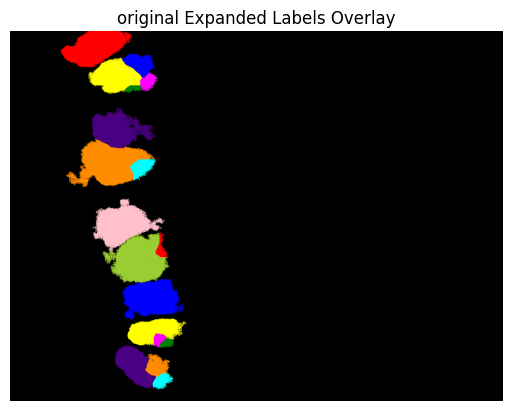

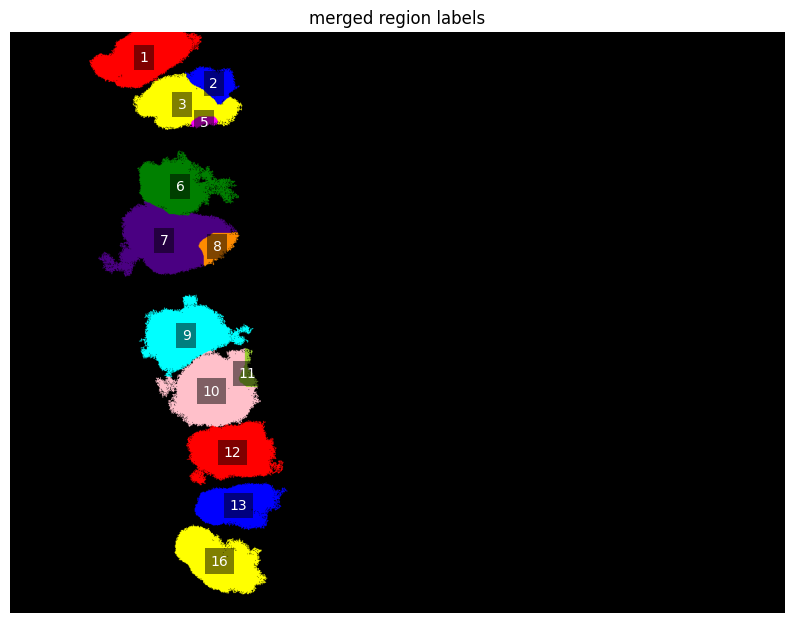

In [55]:
colored = label2rgb(expanded_labels, bg_label=0)
plt.imshow(colored)
plt.title("original Expanded Labels Overlay")
plt.axis('off')
plt.show()

import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.measure import regionprops

def plot_labels_with_numbers(label_array, background=0, title="merged region labels"):
    # Create a color image
    colored = label2rgb(label_array, bg_label=background)

    # Display the color image
    plt.figure(figsize=(10, 10))
    plt.imshow(colored)
    plt.title(title)
    plt.axis('off')

    # Overlay label numbers at centroids
    for region in regionprops(label_array):
        if region.label == background:
            continue
        y, x = region.centroid
        plt.text(x, y, str(region.label), color='white', fontsize=10, ha='center', va='center',
                 bbox=dict(facecolor='black', alpha=0.5, lw=0))

    plt.show()
plot_labels_with_numbers(merged_label_array)


In [56]:
import pandas as pd

# Generate merge decision table
def generate_merge_decision_table(best_stage1, second_stage_results):
    records = []
    for label, (stage1_group, stage1_score) in best_stage1.items():
        stage2_result = second_stage_results.get(label, (None, None))
        stage2_target, stage2_score = stage2_result
        records.append({
            'Label': int(label),
            'Stage1 Group': tuple(int(x) for x in stage1_group),
            'Stage1 Score': round(float(stage1_score), 4),
            'Stage2 Target': int(stage2_target) if stage2_target is not None else None,
            'Stage2 Score': round(float(stage2_score), 4) if stage2_score is not None else None
        })
    return pd.DataFrame.from_records(records)

# Assuming `best_stage1` and `second_stage_results` are available
merge_decision_table = generate_merge_decision_table(best_stage1, second_stage_results)
print(merge_decision_table.to_string(index=False))


 Label Stage1 Group  Stage1 Score  Stage2 Target  Stage2 Score
     1         (1,)        0.1000              1        0.2444
     3 (2, 3, 4, 5)        0.3053              3        0.2186
     2    (2, 3, 4)        0.3291              2        0.1500
     4 (2, 3, 4, 5)        0.2926              3        0.1013
     5    (3, 4, 5)        0.5122              5        0.1242
     6         (6,)        0.1000              6        0.1269
     7         (7,)        0.1000              7        0.1412
     8         (8,)        0.1000              8        0.1300
     9         (9,)        0.1000              9        0.1561
    10        (10,)        0.1000             10        0.1927
    11        (11,)        0.1000             11        0.1415
    12        (12,)        0.1000             12        0.1457
    13 (13, 14, 15)        0.1416             13        0.2163
    14 (13, 14, 15)        0.8755             13        0.3708
    15 (13, 14, 15)        0.4276             13       